<a href="https://colab.research.google.com/github/yevintheenura01/DL_Assignment/blob/Manoj/diabetes_Prediction_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, Dense, Dropout, BatchNormalization, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics as keras_metrics
import joblib
import os



In [17]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [18]:
drive_dir = '/content/drive/MyDrive/DiabetesPrediction/outputs'
model_dir = os.path.join(drive_dir, 'models')
os.makedirs(model_dir, exist_ok=True)


In [19]:
print("Loading preprocessed data...")
train_df = pd.read_csv(os.path.join(drive_dir, "clean_data_train.csv"))
test_df = pd.read_csv(os.path.join(drive_dir, "clean_data_test.csv"))


Loading preprocessed data...


In [20]:
X_train = train_df.drop('diabetes', axis=1).values
y_train = train_df['diabetes'].values

X_test = test_df.drop('diabetes', axis=1).values
y_test = test_df['diabetes'].values

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Class distribution in training: {np.bincount(y_train)}")

Training set shape: (140262, 8)
Test set shape: (35066, 8)
Class distribution in training: [70131 70131]


In [21]:
# ========================================
# 2. RESHAPE DATA FOR CNN
# ========================================
# CNN expects 3D input: (samples, features, channels)
# We'll treat each feature as a timestep and add a channel dimension
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"\nReshaped training data: {X_train_cnn.shape}")
print(f"Reshaped test data: {X_test_cnn.shape}")


Reshaped training data: (140262, 8, 1)
Reshaped test data: (35066, 8, 1)


In [23]:
# ========================================
# 3. BUILD CNN MODEL
# ========================================
from tensorflow.keras import layers, models

def build_cnn_model(input_shape):
    """
    Build a 1D CNN model for diabetes prediction
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv1D(filters=64, kernel_size=3, activation='relu',
                      padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Second Convolutional Block
        layers.Conv1D(filters=128, kernel_size=3, activation='relu',
                      padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),

        # Third Convolutional Block
        layers.Conv1D(filters=256, kernel_size=3, activation='relu',
                      padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        # Global Average Pooling
        layers.GlobalAveragePooling1D(),

        # Dense Layers
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Output Layer
        layers.Dense(1, activation='sigmoid')
    ])

    return model

# Build the model
input_shape = (X_train_cnn.shape[1], 1)
model = build_cnn_model(input_shape)

# Display model architecture
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 8, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 4, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,297 (653.50 KB)

 Trainable params: 166,017 (648.50 KB)

 Non-trainable params: 1,280 (5.00 KB)

In [24]:
# ========================================
# 4. COMPILE MODEL
# ========================================
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

In [25]:
# ========================================
# 5. DEFINE CALLBACKS
# ========================================
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    ),

    # Save best model
    ModelCheckpoint(
        filepath=os.path.join(model_dir, 'best_cnn_model.h5'),
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

In [ ]:
# ========================================
# 6. TRAIN MODEL
# ========================================
print("\n" + "="*50)
print("Starting Model Training...")
print("="*50 + "\n")

history = model.fit(
    X_train_cnn, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Starting Model Training...

Epoch 1/100
1751/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8506 - auc: 0.9328 - loss: 0.3302 - precision: 0.8485 - recall: 0.8534
Epoch 1: val_auc improved from -inf to 0.97465, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8506 - auc: 0.9329 - loss: 0.3301 - precision: 0.8486 - recall: 0.8534 - val_accuracy: 0.9041 - val_auc: 0.9747 - val_loss: 0.2035 - val_precision: 0.8701 - val_recall: 0.9499 - learning_rate: 0.0010
Epoch 2/100
1751/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8878 - auc: 0.9639 - loss: 0.2386 - precision: 0.8776 - recall: 0.9015
Epoch 2: val_auc improved from 0.97465 to 0.97607, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.8878 - auc: 0.9639 - loss: 0.2386 - precision: 0.8776 - recall: 0.9015 - val_accuracy: 0.9019 - val_auc: 0.9761 - val_loss: 0.2005 - val_precision: 0.8564 - val_recall: 0.9657 - learning_rate: 0.0010
Epoch 3/100
1751/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8955 - auc: 0.9691 - loss: 0.2202 - precision: 0.8835 - recall: 0.9111
Epoch 3: val_auc improved from 0.97607 to 0.97767, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - accuracy: 0.8955 - auc: 0.9691 - loss: 0.2202 - precision: 0.8835 - recall: 0.9111 - val_accuracy: 0.9101 - val_auc: 0.9777 - val_loss: 0.1865 - val_precision: 0.8881 - val_recall: 0.9383 - learning_rate: 0.0010
Epoch 4/100
1752/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8966 - auc: 0.9705 - loss: 0.2139 - precision: 0.8873 - recall: 0.9101
Epoch 4: val_auc improved from 0.97767 to 0.97802, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.8966 - auc: 0.9705 - loss: 0.2139 - precision: 0.8873 - recall: 0.9101 - val_accuracy: 0.9105 - val_auc: 0.9780 - val_loss: 0.1851 - val_precision: 0.8808 - val_recall: 0.9494 - learning_rate: 0.0010
Epoch 5/100
1753/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9014 - auc: 0.9726 - loss: 0.2068 - precision: 0.8917 - recall: 0.9139
Epoch 5: val_auc improved from 0.97802 to 0.97833, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.9014 - auc: 0.9726 - loss: 0.2068 - precision: 0.8917 - recall: 0.9139 - val_accuracy: 0.9106 - val_auc: 0.9783 - val_loss: 0.1822 - val_precision: 0.9021 - val_recall: 0.9210 - learning_rate: 0.0010
Epoch 6/100
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9032 - auc: 0.9737 - loss: 0.2008 - precision: 0.8945 - recall: 0.9145
Epoch 6: val_auc did not improve from 0.97833
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.9032 - auc: 0.9737 - loss: 0.2008 - precision: 0.8945 - recall: 0.9145 - val_accuracy: 0.9100 - val_auc: 0.9783 - val_loss: 0.1827 - val_precision: 0.8767 - val_recall: 0.9541 - learning_rate: 0.0010
Epoch 7/100
1753/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9012 - auc: 0.9733 - loss: 0.2020 - precision: 0.8889 - recall: 0.9175
Epoch 7: val_auc improved from 0.97833 to 0.97890, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.9012 - auc: 0.9733 - loss: 0.2020 - precision: 0.8889 - recall: 0.9175 - val_accuracy: 0.9107 - val_auc: 0.9789 - val_loss: 0.1805 - val_precision: 0.8805 - val_recall: 0.9502 - learning_rate: 0.0010
Epoch 8/100
1751/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9051 - auc: 0.9749 - loss: 0.1959 - precision: 0.8942 - recall: 0.9199
Epoch 8: val_auc did not improve from 0.97890
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.9051 - auc: 0.9749 - loss: 0.1959 - precision: 0.8942 - recall: 0.9199 - val_accuracy: 0.9109 - val_auc: 0.9782 - val_loss: 0.1816 - val_precision: 0.8939 - val_recall: 0.9324 - learning_rate: 0.0010
Epoch 9/100
1751/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9051 - auc: 0.9748 - loss: 0.1961 - precision: 0.8931 - recall: 0.9199
Epoch 9: val_auc did not improve from 0.97890
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 79s 22ms/step - accuracy: 0.9051 - auc: 0.9748 - loss: 0.1961 - precision: 0.

1754/1754 ━━━━━━━━━━━━━━━━━━━━ 36s 20ms/step - accuracy: 0.9058 - auc: 0.9757 - loss: 0.1923 - precision: 0.8937 - recall: 0.9199 - val_accuracy: 0.9131 - val_auc: 0.9791 - val_loss: 0.1779 - val_precision: 0.8963 - val_recall: 0.9342 - learning_rate: 0.0010
Epoch 12/100
1753/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9051 - auc: 0.9749 - loss: 0.1956 - precision: 0.8953 - recall: 0.9177
Epoch 12: val_auc did not improve from 0.97908
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.9051 - auc: 0.9749 - loss: 0.1956 - precision: 0.8953 - recall: 0.9177 - val_accuracy: 0.9100 - val_auc: 0.9788 - val_loss: 0.1795 - val_precision: 0.9129 - val_recall: 0.9065 - learning_rate: 0.0010
Epoch 13/100
1752/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9056 - auc: 0.9750 - loss: 0.1945 - precision: 0.8950 - recall: 0.9207
Epoch 13: val_auc did not improve from 0.97908
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 35s 20ms/step - accuracy: 0.9056 - auc: 0.9750 - loss: 0.1945 - precision

1754/1754 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.9049 - auc: 0.9757 - loss: 0.1920 - precision: 0.8956 - recall: 0.9167 - val_accuracy: 0.9125 - val_auc: 0.9792 - val_loss: 0.1774 - val_precision: 0.8984 - val_recall: 0.9300 - learning_rate: 0.0010
Epoch 15/100
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9078 - auc: 0.9764 - loss: 0.1896 - precision: 0.8989 - recall: 0.9177
Epoch 15: val_auc improved from 0.97915 to 0.97924, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - accuracy: 0.9078 - auc: 0.9764 - loss: 0.1896 - precision: 0.8989 - recall: 0.9177 - val_accuracy: 0.9123 - val_auc: 0.9792 - val_loss: 0.1772 - val_precision: 0.8904 - val_recall: 0.9402 - learning_rate: 0.0010
Epoch 16/100
1751/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9059 - auc: 0.9758 - loss: 0.1915 - precision: 0.8956 - recall: 0.9193
Epoch 16: val_auc improved from 0.97924 to 0.97962, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.9059 - auc: 0.9758 - loss: 0.1915 - precision: 0.8956 - recall: 0.9193 - val_accuracy: 0.9144 - val_auc: 0.9796 - val_loss: 0.1758 - val_precision: 0.8914 - val_recall: 0.9437 - learning_rate: 0.0010
Epoch 17/100
1752/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9089 - auc: 0.9767 - loss: 0.1880 - precision: 0.8973 - recall: 0.9226
Epoch 17: val_auc improved from 0.97962 to 0.97983, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.9089 - auc: 0.9767 - loss: 0.1880 - precision: 0.8973 - recall: 0.9226 - val_accuracy: 0.9142 - val_auc: 0.9798 - val_loss: 0.1758 - val_precision: 0.8901 - val_recall: 0.9449 - learning_rate: 0.0010
Epoch 18/100
1752/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9074 - auc: 0.9765 - loss: 0.1892 - precision: 0.8979 - recall: 0.9200
Epoch 18: val_auc did not improve from 0.97983
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.9074 - auc: 0.9765 - loss: 0.1892 - precision: 0.8979 - recall: 0.9200 - val_accuracy: 0.9112 - val_auc: 0.9788 - val_loss: 0.1796 - val_precision: 0.8986 - val_recall: 0.9269 - learning_rate: 0.0010
Epoch 19/100
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9068 - auc: 0.9764 - loss: 0.1893 - precision: 0.8980 - recall: 0.9187
Epoch 19: val_auc did not improve from 0.97983
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - accuracy: 0.9068 - auc: 0.9764 - loss: 0.1893 - precision

1754/1754 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.9068 - auc: 0.9765 - loss: 0.1888 - precision: 0.8964 - recall: 0.9190 - val_accuracy: 0.9145 - val_auc: 0.9800 - val_loss: 0.1740 - val_precision: 0.9024 - val_recall: 0.9294 - learning_rate: 0.0010
Epoch 21/100
1753/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9085 - auc: 0.9763 - loss: 0.1890 - precision: 0.8959 - recall: 0.9249
Epoch 21: val_auc did not improve from 0.98003
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.9085 - auc: 0.9763 - loss: 0.1890 - precision: 0.8959 - recall: 0.9249 - val_accuracy: 0.9127 - val_auc: 0.9794 - val_loss: 0.1760 - val_precision: 0.9140 - val_recall: 0.9111 - learning_rate: 0.0010
Epoch 22/100
1751/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9094 - auc: 0.9773 - loss: 0.1855 - precision: 0.8997 - recall: 0.9224
Epoch 22: val_auc did not improve from 0.98003
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 36s 20ms/step - accuracy: 0.9094 - auc: 0.9773 - loss: 0.1855 - precision

1754/1754 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.9104 - auc: 0.9777 - loss: 0.1844 - precision: 0.9007 - recall: 0.9227 - val_accuracy: 0.9148 - val_auc: 0.9804 - val_loss: 0.1731 - val_precision: 0.8893 - val_recall: 0.9474 - learning_rate: 0.0010
Epoch 28/100
1752/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9097 - auc: 0.9771 - loss: 0.1862 - precision: 0.8986 - recall: 0.9235
Epoch 28: val_auc did not improve from 0.98042
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.9097 - auc: 0.9771 - loss: 0.1862 - precision: 0.8986 - recall: 0.9235 - val_accuracy: 0.9133 - val_auc: 0.9799 - val_loss: 0.1743 - val_precision: 0.9094 - val_recall: 0.9179 - learning_rate: 0.0010
Epoch 29/100
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9094 - auc: 0.9770 - loss: 0.1856 - precision: 0.8992 - recall: 0.9218
Epoch 29: val_auc did not improve from 0.98042
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.9094 - auc: 0.9770 - loss: 0.1856 - precision

1754/1754 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step - accuracy: 0.9105 - auc: 0.9781 - loss: 0.1818 - precision: 0.8995 - recall: 0.9242 - val_accuracy: 0.9167 - val_auc: 0.9805 - val_loss: 0.1714 - val_precision: 0.8990 - val_recall: 0.9387 - learning_rate: 0.0010
Epoch 37/100
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9108 - auc: 0.9779 - loss: 0.1827 - precision: 0.9006 - recall: 0.9233
Epoch 37: val_auc did not improve from 0.98053
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.9108 - auc: 0.9779 - loss: 0.1827 - precision: 0.9006 - recall: 0.9233 - val_accuracy: 0.9152 - val_auc: 0.9803 - val_loss: 0.1728 - val_precision: 0.9041 - val_recall: 0.9289 - learning_rate: 0.0010
Epoch 38/100
1753/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9121 - auc: 0.9782 - loss: 0.1815 - precision: 0.9017 - recall: 0.9247
Epoch 38: val_auc improved from 0.98053 to 0.98080, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.9121 - auc: 0.9782 - loss: 0.1815 - precision: 0.9017 - recall: 0.9247 - val_accuracy: 0.9157 - val_auc: 0.9808 - val_loss: 0.1698 - val_precision: 0.9050 - val_recall: 0.9290 - learning_rate: 0.0010
Epoch 39/100
1753/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9099 - auc: 0.9779 - loss: 0.1824 - precision: 0.9008 - recall: 0.9208
Epoch 39: val_auc improved from 0.98080 to 0.98103, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.9099 - auc: 0.9779 - loss: 0.1824 - precision: 0.9008 - recall: 0.9208 - val_accuracy: 0.9177 - val_auc: 0.9810 - val_loss: 0.1698 - val_precision: 0.9002 - val_recall: 0.9396 - learning_rate: 0.0010
Epoch 40/100
1753/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9104 - auc: 0.9783 - loss: 0.1808 - precision: 0.8995 - recall: 0.9227
Epoch 40: val_auc did not improve from 0.98103
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.9104 - auc: 0.9783 - loss: 0.1808 - precision: 0.8995 - recall: 0.9227 - val_accuracy: 0.9149 - val_auc: 0.9806 - val_loss: 0.1721 - val_precision: 0.9097 - val_recall: 0.9212 - learning_rate: 0.0010
Epoch 41/100
1751/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9122 - auc: 0.9786 - loss: 0.1798 - precision: 0.9031 - recall: 0.9232
Epoch 41: val_auc did not improve from 0.98103
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.9122 - auc: 0.9786 - loss: 0.1798 - precision

1754/1754 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.9137 - auc: 0.9793 - loss: 0.1774 - precision: 0.9053 - recall: 0.9241 - val_accuracy: 0.9176 - val_auc: 0.9815 - val_loss: 0.1673 - val_precision: 0.9040 - val_recall: 0.9344 - learning_rate: 5.0000e-04
Epoch 47/100
1752/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9146 - auc: 0.9793 - loss: 0.1773 - precision: 0.9051 - recall: 0.9274
Epoch 47: val_auc did not improve from 0.98149
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.9146 - auc: 0.9793 - loss: 0.1773 - precision: 0.9051 - recall: 0.9274 - val_accuracy: 0.9175 - val_auc: 0.9814 - val_loss: 0.1672 - val_precision: 0.9091 - val_recall: 0.9277 - learning_rate: 5.0000e-04
Epoch 48/100
1751/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9132 - auc: 0.9794 - loss: 0.1759 - precision: 0.9041 - recall: 0.9242
Epoch 48: val_auc did not improve from 0.98149
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 43s 19ms/step - accuracy: 0.9132 - auc: 0.9794 - loss: 0.1759 - p

1754/1754 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.9144 - auc: 0.9793 - loss: 0.1761 - precision: 0.9037 - recall: 0.9276 - val_accuracy: 0.9187 - val_auc: 0.9817 - val_loss: 0.1669 - val_precision: 0.9053 - val_recall: 0.9351 - learning_rate: 5.0000e-04
Epoch 50/100
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9130 - auc: 0.9792 - loss: 0.1771 - precision: 0.9022 - recall: 0.9253
Epoch 50: val_auc did not improve from 0.98168
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 34s 19ms/step - accuracy: 0.9130 - auc: 0.9792 - loss: 0.1771 - precision: 0.9022 - recall: 0.9253 - val_accuracy: 0.9172 - val_auc: 0.9815 - val_loss: 0.1675 - val_precision: 0.9032 - val_recall: 0.9344 - learning_rate: 5.0000e-04
Epoch 51/100
1751/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9157 - auc: 0.9799 - loss: 0.1740 - precision: 0.9050 - recall: 0.9291
Epoch 51: val_auc improved from 0.98168 to 0.98175, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.9157 - auc: 0.9799 - loss: 0.1740 - precision: 0.9050 - recall: 0.9291 - val_accuracy: 0.9184 - val_auc: 0.9818 - val_loss: 0.1656 - val_precision: 0.9058 - val_recall: 0.9339 - learning_rate: 5.0000e-04
Epoch 52/100
1752/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9129 - auc: 0.9794 - loss: 0.1762 - precision: 0.9019 - recall: 0.9262
Epoch 52: val_auc did not improve from 0.98175
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.9129 - auc: 0.9794 - loss: 0.1762 - precision: 0.9019 - recall: 0.9262 - val_accuracy: 0.9173 - val_auc: 0.9813 - val_loss: 0.1683 - val_precision: 0.9066 - val_recall: 0.9302 - learning_rate: 5.0000e-04
Epoch 53/100
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9131 - auc: 0.9793 - loss: 0.1760 - precision: 0.9033 - recall: 0.9249
Epoch 53: val_auc did not improve from 0.98175
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 35s 20ms/step - accuracy: 0.9131 - auc: 0.9793 - loss: 0.1760 - p

1754/1754 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.9137 - auc: 0.9796 - loss: 0.1754 - precision: 0.9035 - recall: 0.9262 - val_accuracy: 0.9188 - val_auc: 0.9819 - val_loss: 0.1662 - val_precision: 0.8997 - val_recall: 0.9427 - learning_rate: 5.0000e-04
Epoch 55/100
1752/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9140 - auc: 0.9794 - loss: 0.1758 - precision: 0.9013 - recall: 0.9303
Epoch 55: val_auc improved from 0.98188 to 0.98193, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.9140 - auc: 0.9794 - loss: 0.1758 - precision: 0.9014 - recall: 0.9303 - val_accuracy: 0.9185 - val_auc: 0.9819 - val_loss: 0.1655 - val_precision: 0.8974 - val_recall: 0.9449 - learning_rate: 5.0000e-04
Epoch 56/100
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9144 - auc: 0.9800 - loss: 0.1734 - precision: 0.9025 - recall: 0.9289
Epoch 56: val_auc did not improve from 0.98193
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.9144 - auc: 0.9800 - loss: 0.1734 - precision: 0.9025 - recall: 0.9289 - val_accuracy: 0.9187 - val_auc: 0.9818 - val_loss: 0.1656 - val_precision: 0.9039 - val_recall: 0.9370 - learning_rate: 5.0000e-04
Epoch 57/100
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9145 - auc: 0.9799 - loss: 0.1736 - precision: 0.9040 - recall: 0.9271
Epoch 57: val_auc did not improve from 0.98193
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 34s 20ms/step - accuracy: 0.9145 - auc: 0.9799 - loss: 0.1736 - p

1754/1754 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.9140 - auc: 0.9796 - loss: 0.1747 - precision: 0.9022 - recall: 0.9284 - val_accuracy: 0.9181 - val_auc: 0.9821 - val_loss: 0.1649 - val_precision: 0.8951 - val_recall: 0.9471 - learning_rate: 5.0000e-04
Epoch 59/100
1751/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9146 - auc: 0.9797 - loss: 0.1743 - precision: 0.9035 - recall: 0.9283
Epoch 59: val_auc did not improve from 0.98205
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.9146 - auc: 0.9797 - loss: 0.1743 - precision: 0.9035 - recall: 0.9283 - val_accuracy: 0.9189 - val_auc: 0.9820 - val_loss: 0.1661 - val_precision: 0.9061 - val_recall: 0.9346 - learning_rate: 5.0000e-04
Epoch 60/100
1751/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9161 - auc: 0.9804 - loss: 0.1720 - precision: 0.9049 - recall: 0.9302
Epoch 60: val_auc did not improve from 0.98205
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.9161 - auc: 0.9804 - loss: 0.1721 - p

1754/1754 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.9134 - auc: 0.9795 - loss: 0.1752 - precision: 0.9043 - recall: 0.9258 - val_accuracy: 0.9184 - val_auc: 0.9821 - val_loss: 0.1658 - val_precision: 0.8919 - val_recall: 0.9522 - learning_rate: 5.0000e-04
Epoch 65/100
1753/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9148 - auc: 0.9800 - loss: 0.1738 - precision: 0.9028 - recall: 0.9293
Epoch 65: val_auc improved from 0.98206 to 0.98223, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 34s 19ms/step - accuracy: 0.9148 - auc: 0.9800 - loss: 0.1738 - precision: 0.9028 - recall: 0.9293 - val_accuracy: 0.9196 - val_auc: 0.9822 - val_loss: 0.1637 - val_precision: 0.9109 - val_recall: 0.9301 - learning_rate: 5.0000e-04
Epoch 66/100
1752/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9152 - auc: 0.9800 - loss: 0.1734 - precision: 0.9045 - recall: 0.9295
Epoch 66: val_auc did not improve from 0.98223
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 34s 19ms/step - accuracy: 0.9152 - auc: 0.9800 - loss: 0.1734 - precision: 0.9045 - recall: 0.9295 - val_accuracy: 0.9186 - val_auc: 0.9822 - val_loss: 0.1641 - val_precision: 0.9113 - val_recall: 0.9275 - learning_rate: 5.0000e-04
Epoch 67/100
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9163 - auc: 0.9802 - loss: 0.1724 - precision: 0.9064 - recall: 0.9282
Epoch 67: val_auc improved from 0.98223 to 0.98225, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.9163 - auc: 0.9802 - loss: 0.1724 - precision: 0.9064 - recall: 0.9282 - val_accuracy: 0.9198 - val_auc: 0.9823 - val_loss: 0.1641 - val_precision: 0.9077 - val_recall: 0.9345 - learning_rate: 5.0000e-04
Epoch 68/100
1753/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9157 - auc: 0.9801 - loss: 0.1727 - precision: 0.9056 - recall: 0.9288
Epoch 68: val_auc improved from 0.98225 to 0.98227, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 34s 19ms/step - accuracy: 0.9157 - auc: 0.9801 - loss: 0.1727 - precision: 0.9056 - recall: 0.9288 - val_accuracy: 0.9197 - val_auc: 0.9823 - val_loss: 0.1637 - val_precision: 0.9097 - val_recall: 0.9318 - learning_rate: 5.0000e-04
Epoch 69/100
1753/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9148 - auc: 0.9797 - loss: 0.1742 - precision: 0.9063 - recall: 0.9261
Epoch 69: val_auc did not improve from 0.98227
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.9148 - auc: 0.9797 - loss: 0.1742 - precision: 0.9063 - recall: 0.9261 - val_accuracy: 0.9184 - val_auc: 0.9818 - val_loss: 0.1655 - val_precision: 0.9107 - val_recall: 0.9278 - learning_rate: 5.0000e-04
Epoch 70/100
1751/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9149 - auc: 0.9799 - loss: 0.1742 - precision: 0.9052 - recall: 0.9277
Epoch 70: val_auc improved from 0.98227 to 0.98242, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.9149 - auc: 0.9799 - loss: 0.1742 - precision: 0.9052 - recall: 0.9277 - val_accuracy: 0.9199 - val_auc: 0.9824 - val_loss: 0.1631 - val_precision: 0.9034 - val_recall: 0.9402 - learning_rate: 5.0000e-04
Epoch 71/100
1752/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9151 - auc: 0.9800 - loss: 0.1731 - precision: 0.9047 - recall: 0.9282
Epoch 71: val_auc did not improve from 0.98242
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 35s 20ms/step - accuracy: 0.9151 - auc: 0.9800 - loss: 0.1731 - precision: 0.9047 - recall: 0.9282 - val_accuracy: 0.9188 - val_auc: 0.9822 - val_loss: 0.1635 - val_precision: 0.9085 - val_recall: 0.9314 - learning_rate: 5.0000e-04
Epoch 72/100
1752/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9138 - auc: 0.9798 - loss: 0.1742 - precision: 0.9043 - recall: 0.9255
Epoch 72: val_auc did not improve from 0.98242
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.9138 - auc: 0.9798 - loss: 0.1742 - p

1754/1754 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.9147 - auc: 0.9802 - loss: 0.1725 - precision: 0.9048 - recall: 0.9270 - val_accuracy: 0.9203 - val_auc: 0.9826 - val_loss: 0.1623 - val_precision: 0.9050 - val_recall: 0.9392 - learning_rate: 2.5000e-04
Epoch 79/100
1752/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9165 - auc: 0.9811 - loss: 0.1689 - precision: 0.9069 - recall: 0.9291
Epoch 79: val_auc improved from 0.98257 to 0.98267, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.9165 - auc: 0.9811 - loss: 0.1689 - precision: 0.9069 - recall: 0.9291 - val_accuracy: 0.9208 - val_auc: 0.9827 - val_loss: 0.1625 - val_precision: 0.9039 - val_recall: 0.9417 - learning_rate: 2.5000e-04
Epoch 80/100
1753/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9150 - auc: 0.9800 - loss: 0.1731 - precision: 0.9048 - recall: 0.9287
Epoch 80: val_auc did not improve from 0.98267
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 35s 20ms/step - accuracy: 0.9150 - auc: 0.9800 - loss: 0.1731 - precision: 0.9048 - recall: 0.9287 - val_accuracy: 0.9198 - val_auc: 0.9826 - val_loss: 0.1616 - val_precision: 0.9082 - val_recall: 0.9339 - learning_rate: 2.5000e-04
Epoch 81/100
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9165 - auc: 0.9807 - loss: 0.1705 - precision: 0.9066 - recall: 0.9290
Epoch 81: val_auc improved from 0.98267 to 0.98284, saving model to /content/drive/MyDrive/DiabetesPrediction/outputs/models/best_cnn_model.h5


1754/1754 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.9165 - auc: 0.9807 - loss: 0.1705 - precision: 0.9066 - recall: 0.9290 - val_accuracy: 0.9207 - val_auc: 0.9828 - val_loss: 0.1612 - val_precision: 0.9035 - val_recall: 0.9419 - learning_rate: 2.5000e-04
Epoch 82/100
1753/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9169 - auc: 0.9806 - loss: 0.1709 - precision: 0.9061 - recall: 0.9298
Epoch 82: val_auc did not improve from 0.98284
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 36s 20ms/step - accuracy: 0.9169 - auc: 0.9806 - loss: 0.1709 - precision: 0.9061 - recall: 0.9298 - val_accuracy: 0.9208 - val_auc: 0.9828 - val_loss: 0.1613 - val_precision: 0.9049 - val_recall: 0.9404 - learning_rate: 2.5000e-04
Epoch 83/100
1751/1754 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9172 - auc: 0.9807 - loss: 0.1704 - precision: 0.9068 - recall: 0.9314
Epoch 83: val_auc did not improve from 0.98284
1754/1754 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - accuracy: 0.9172 - auc: 0.9807 - loss: 0.1704 - p

In [26]:
# ========================================
# 7. EVALUATE MODEL
# ========================================
print("\n" + "="*50)
print("Evaluating Model on Test Set...")
print("="*50 + "\n")

# Load best model
best_model = keras.models.load_model(os.path.join(model_dir, 'best_cnn_model.h5'))

# Evaluate on test set
test_loss, test_acc, test_precision, test_recall, test_auc = best_model.evaluate(
    X_test_cnn, y_test, verbose=0
)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test F1-Score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")




Evaluating Model on Test Set...



Test Accuracy: 0.9197
Test Precision: 0.8972
Test Recall: 0.9480
Test AUC: 0.9826
Test F1-Score: 0.9219


In [27]:
# ========================================
# 8. PREDICTIONS AND DETAILED METRICS
# ========================================
# Get predictions
y_pred_proba = best_model.predict(X_test_cnn)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Classification Report
print("\n" + "="*50)
print("Classification Report")
print("="*50)
print(classification_report(y_test, y_pred, target_names=['Non-Diabetic', 'Diabetic']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)



1096/1096 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step

Classification Report
              precision    recall  f1-score   support

Non-Diabetic       0.94      0.89      0.92     17533
    Diabetic       0.90      0.95      0.92     17533

    accuracy                           0.92     35066
   macro avg       0.92      0.92      0.92     35066
weighted avg       0.92      0.92      0.92     35066


Confusion Matrix:
[[15629  1904]
 [  911 16622]]


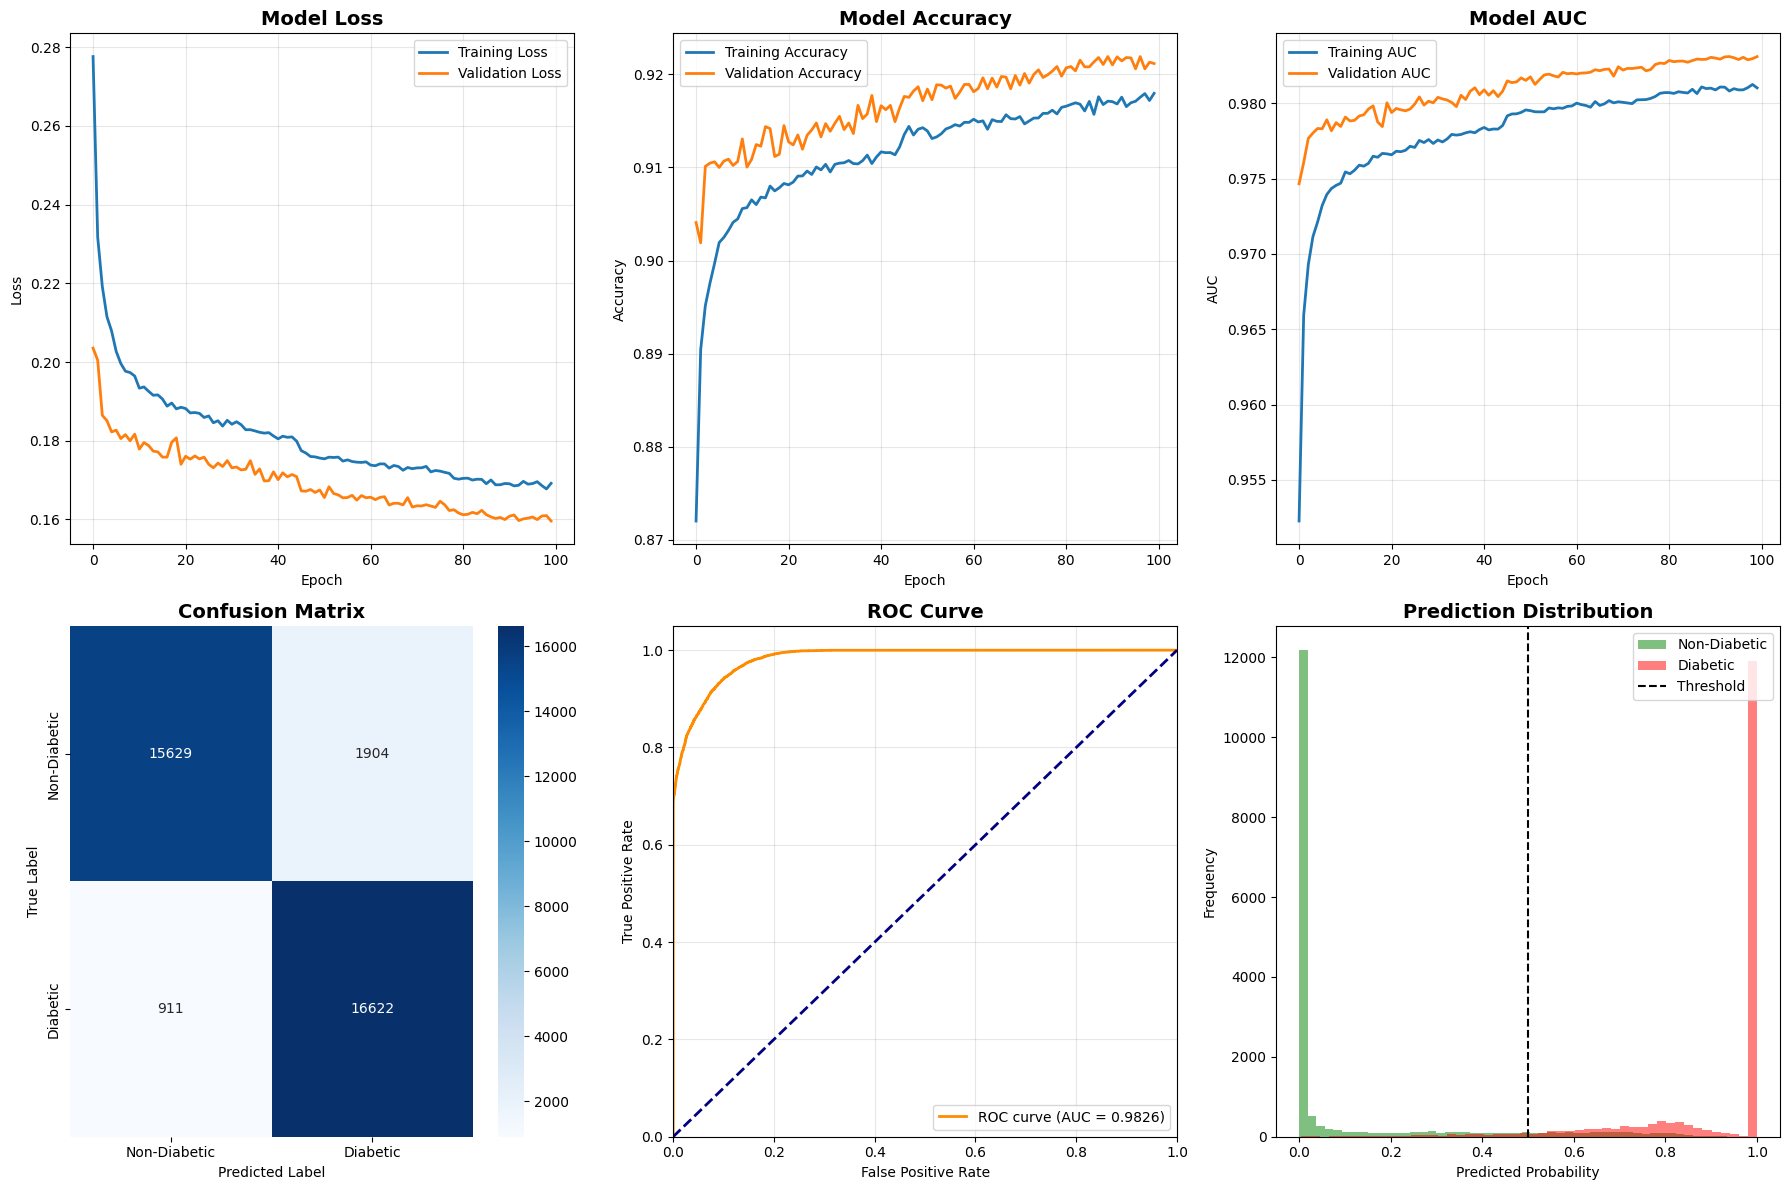

In [32]:
# ========================================
# 9. VISUALIZATION
# ========================================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Training History - Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Training History - Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Training History - AUC
axes[0, 2].plot(history.history['auc'], label='Training AUC', linewidth=2)
axes[0, 2].plot(history.history['val_auc'], label='Validation AUC', linewidth=2)
axes[0, 2].set_title('Model AUC', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('AUC')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Non-Diabetic', 'Diabetic'],
            yticklabels=['Non-Diabetic', 'Diabetic'])
axes[1, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')

# 5. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
axes[1, 1].plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(True, alpha=0.3)

# 6. Prediction Distribution
axes[1, 2].hist(y_pred_proba[y_test == 0], bins=50, alpha=0.5,
                label='Non-Diabetic', color='green')
axes[1, 2].hist(y_pred_proba[y_test == 1], bins=50, alpha=0.5,
                label='Diabetic', color='red')
axes[1, 2].axvline(x=0.5, color='black', linestyle='--', label='Threshold')
axes[1, 2].set_title('Prediction Distribution', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Predicted Probability')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend()

plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'cnn_model_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

In [33]:
# ========================================
# 10. SAVE FINAL MODEL
# ========================================
# Save model in multiple formats
best_model.save(os.path.join(model_dir, 'diabetes_cnn_final.h5'))
best_model.save(os.path.join(model_dir, 'diabetes_cnn_final.keras'))

# Save model architecture
with open(os.path.join(model_dir, 'model_architecture.json'), 'w') as f:
    f.write(best_model.to_json())

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(model_dir, 'training_history.csv'), index=False)

# Save predictions
results_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'y_pred_proba': y_pred_proba.flatten()
})
results_df.to_csv(os.path.join(model_dir, 'test_predictions.csv'), index=False)

print("\n" + "="*50)
print("Model Training Complete!")
print("="*50)
print(f"\nAll files saved to: {model_dir}")
print("\nSaved files:")
print("  - best_cnn_model.h5")
print("  - diabetes_cnn_final.h5")
print("  - diabetes_cnn_final.keras")
print("  - model_architecture.json")
print("  - training_history.csv")
print("  - test_predictions.csv")
print("  - cnn_model_performance.png")



Model Training Complete!

All files saved to: /content/drive/MyDrive/DiabetesPrediction/outputs/models

Saved files:
  - best_cnn_model.h5
  - diabetes_cnn_final.h5
  - diabetes_cnn_final.keras
  - model_architecture.json
  - training_history.csv
  - test_predictions.csv
  - cnn_model_performance.png


In [34]:
# ========================================
# 11. INFERENCE FUNCTION
# ========================================
def predict_diabetes(features):
    """
    Make predictions on new data

    Parameters:
    features: array-like, shape (n_samples, 8)
              Features: [gender, age, hypertension, heart_disease,
                        smoking_history, bmi, HbA1c_level, blood_glucose_level]

    Returns:
    predictions: array of probabilities
    """
    # Load scaler and encoder
    scaler = joblib.load(os.path.join(drive_dir, 'scaler.pkl'))

    # Scale features
    features_scaled = scaler.transform(features)

    # Reshape for CNN
    features_cnn = features_scaled.reshape(features_scaled.shape[0],
                                          features_scaled.shape[1], 1)

    # Make predictions
    predictions = best_model.predict(features_cnn)

    return predictions

# Example usage
print("\n" + "="*50)
print("Example Prediction")
print("="*50)

# Example: Female, 45 years old, no hypertension, no heart disease,
# never smoked, BMI 27.5, HbA1c 6.5, blood glucose 140
example_data = np.array([[0, 45, 0, 0, 3, 27.5, 6.5, 140]])
prediction = predict_diabetes(example_data)
print(f"\nPrediction probability: {prediction[0][0]:.4f}")
print(f"Prediction: {'Diabetic' if prediction[0][0] > 0.5 else 'Non-Diabetic'}")


Example Prediction
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

Prediction probability: 0.2436
Prediction: Non-Diabetic


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
